# PTB ECG Dataset Exploration
In this notebook, the PTB Diagnostic ECG dataset and the following data preprocessing operations are explored:



*   Low frequency filtering
*   PCA dimension reduction
*   FFT transformation




In [1]:
# Installing WFDB
!pip install wfdb

     |████████████████████████████████| 122kB 9.3MB/s 


In [59]:
import wfdb
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from google.colab import drive
import os
import random
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
# Mount the driver
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
# Use the dataset's RECORDS file to get the paths to patients' data
records_to_exclude = [421, 348, 536, 338, 358, 429, 395, 377, 419, 398, 367, 412, 416, 522, 333, 523, 378,
                      375, 397, 519, 530, 406, 524, 355, 356, 407, 417]
record_files = open('/gdrive/MyDrive/Datasets/ptb-diagnostic-ecg-database-1.0.0/RECORDS')
record_files = [os.path.join('/gdrive/MyDrive/Datasets/ptb-diagnostic-ecg-database-1.0.0/', file) for file in record_files.read().split('\n')][:-1]
# record_files = [i for j, i in enumerate(record_files) if j not in records_to_exclude]

In [6]:
print('Total number of records: {}'.format(len(record_files)))

diagnosis_categories = {}

for record_file in record_files:
  record_data = wfdb.io.rdrecord(record_file)
  diagnosis = record_data.comments[4]

  if not diagnosis in diagnosis_categories:
    diagnosis_categories[diagnosis] = 1
  else:
    diagnosis_categories[diagnosis] += 1

Total number of records: 549


In [7]:
for item in diagnosis_categories.items():
  print(item)

('Reason for admission: Myocardial infarction', 368)
('Reason for admission: Healthy control', 80)
('Reason for admission: Valvular heart disease', 6)
('Reason for admission: Dysrhythmia', 16)
('Reason for admission: Heart failure (NYHA 2)', 1)
('Reason for admission: Heart failure (NYHA 3)', 1)
('Reason for admission: n/a', 27)
('Reason for admission: Heart failure (NYHA 4)', 1)
('Reason for admission: Palpitation', 1)
('Reason for admission: Cardiomyopathy', 17)
('Reason for admission: Stable angina', 2)
('Reason for admission: Hypertrophy', 7)
('Reason for admission: Bundle branch block', 17)
('Reason for admission: Unstable angina', 1)
('Reason for admission: Myocarditis', 4)


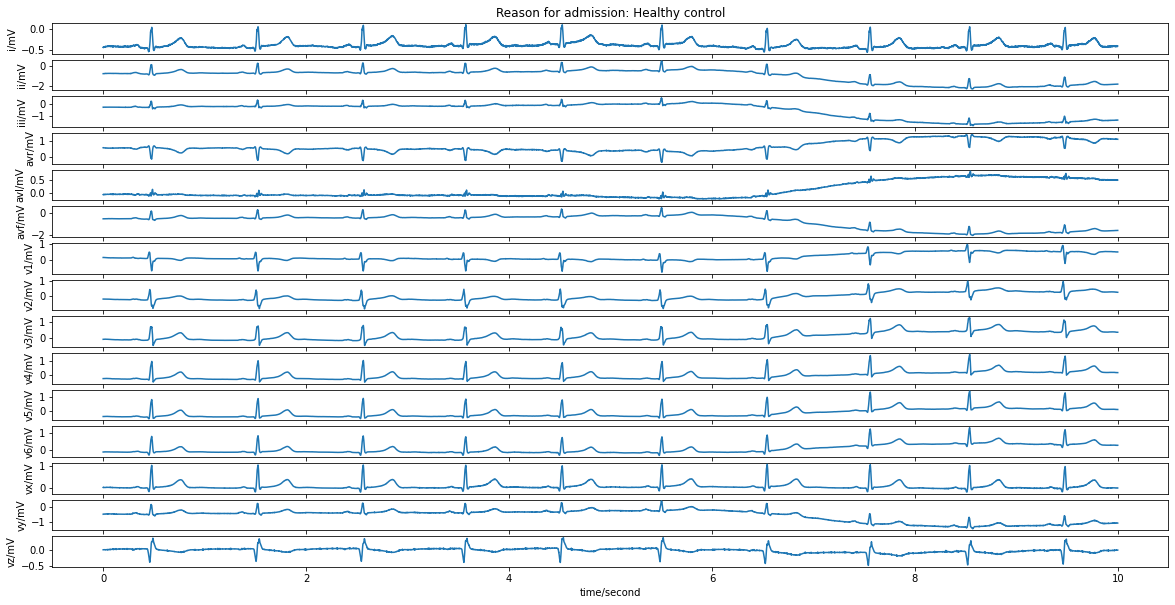

In [13]:
# Plot healthy samples

num_plots = 1
plot_count = 0

for i in range(len(record_files)):
  record_file = random.choice(record_files)
  record_data = wfdb.io.rdrecord(record_file, sampto=10000)

  diagnosis = record_data.comments[4]

  if plot_count is num_plots:
    break

  if 'Healthy' in diagnosis:
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title=diagnosis,
                  figsize=(20,10))
    
    plot_count += 1


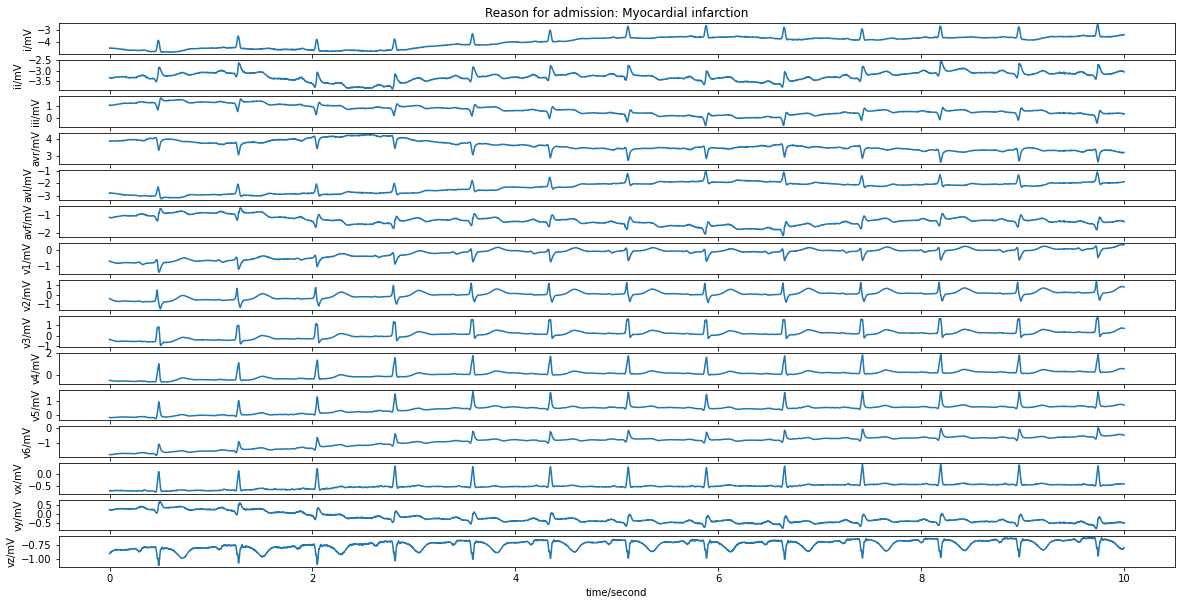

In [14]:
# Plot unhealthy samples

num_plots = 1
plot_count = 0

for i in range(len(record_files)):
  record_file = random.choice(record_files)
  record_data = wfdb.io.rdrecord(record_file, sampto=10000)

  diagnosis = record_data.comments[4]

  if plot_count is num_plots:
    break

  if 'Myocardial' in diagnosis:
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title=diagnosis,
                  figsize=(20,10))
    
    plot_count += 1

10000 samples seems to be enough to capture nuances of the dataset.

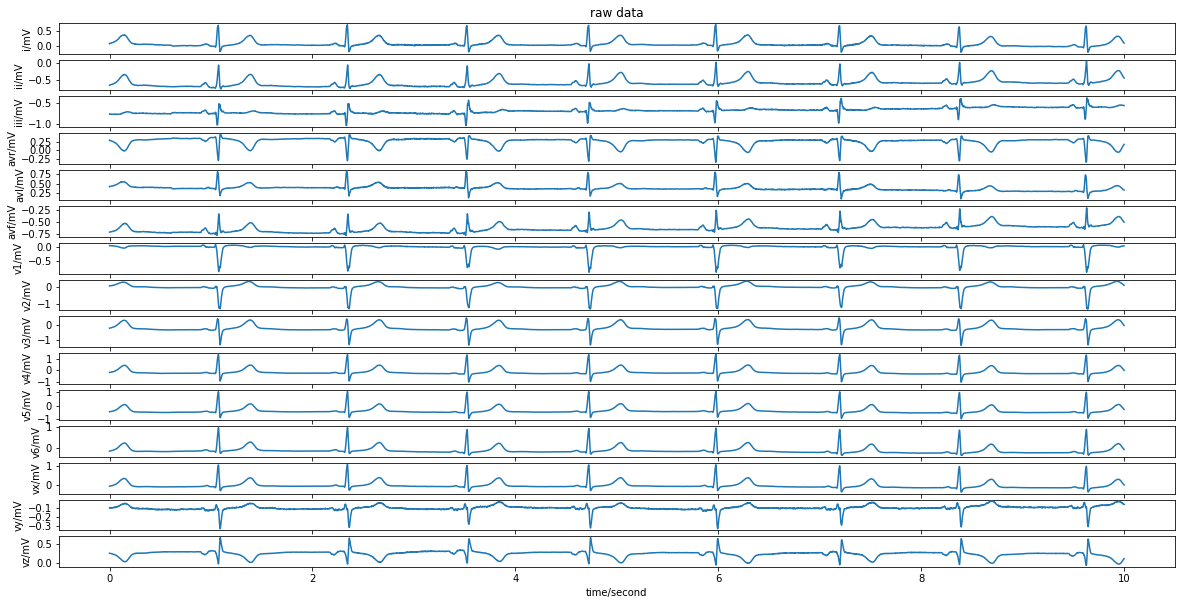

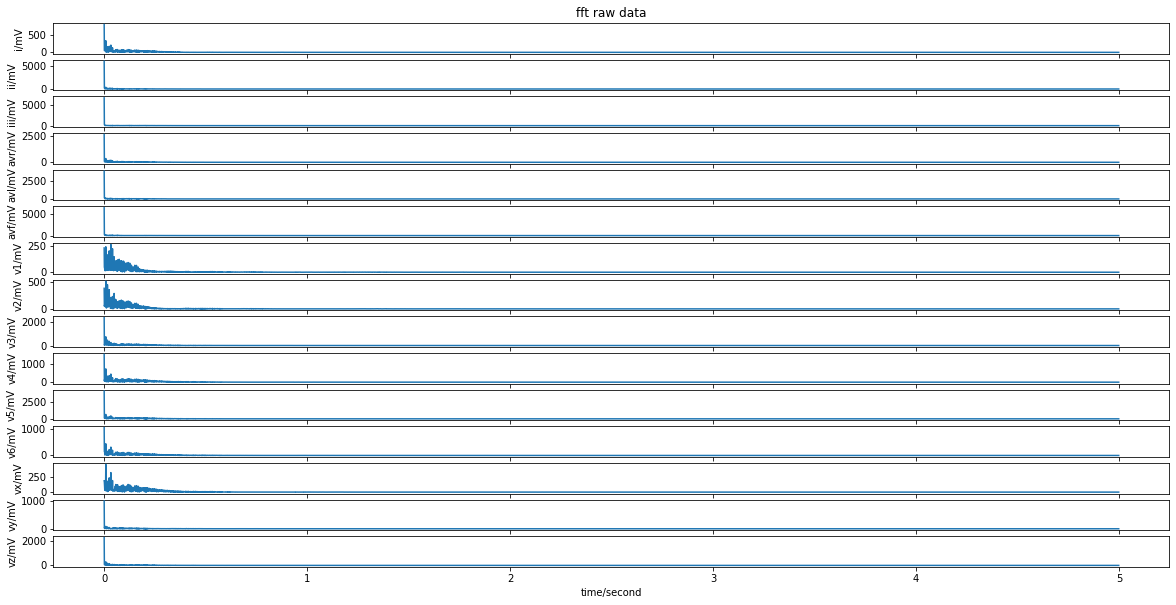

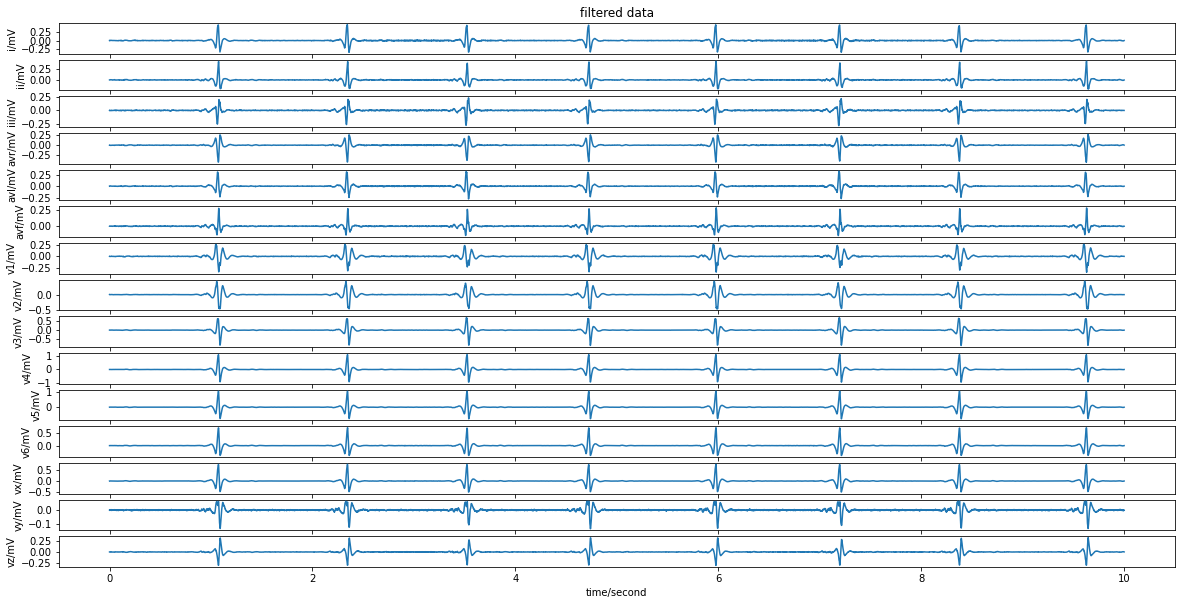

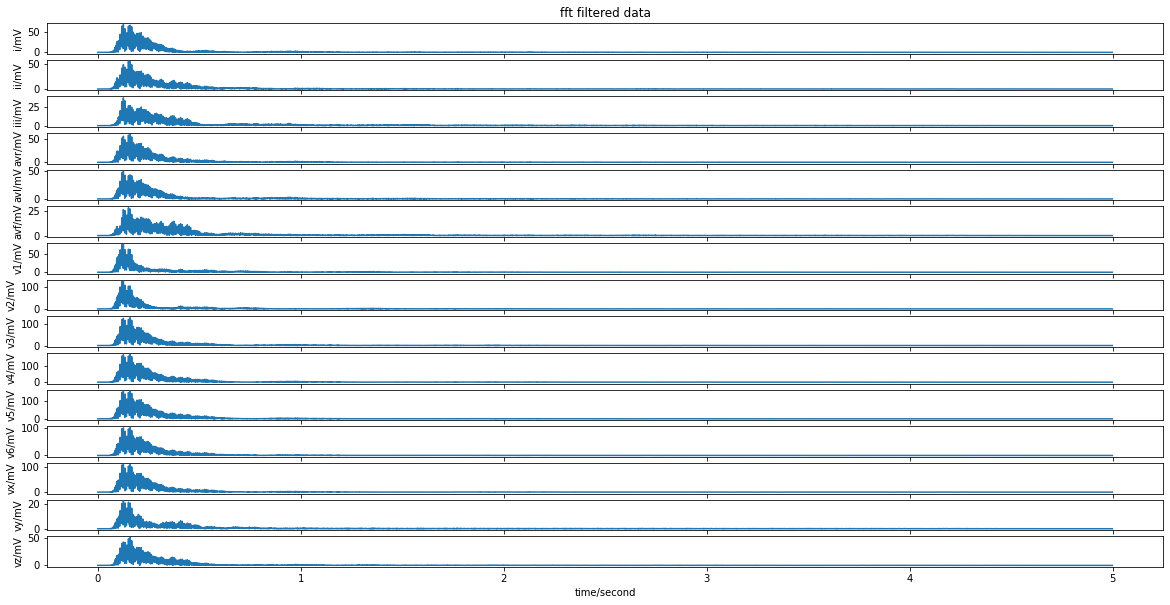

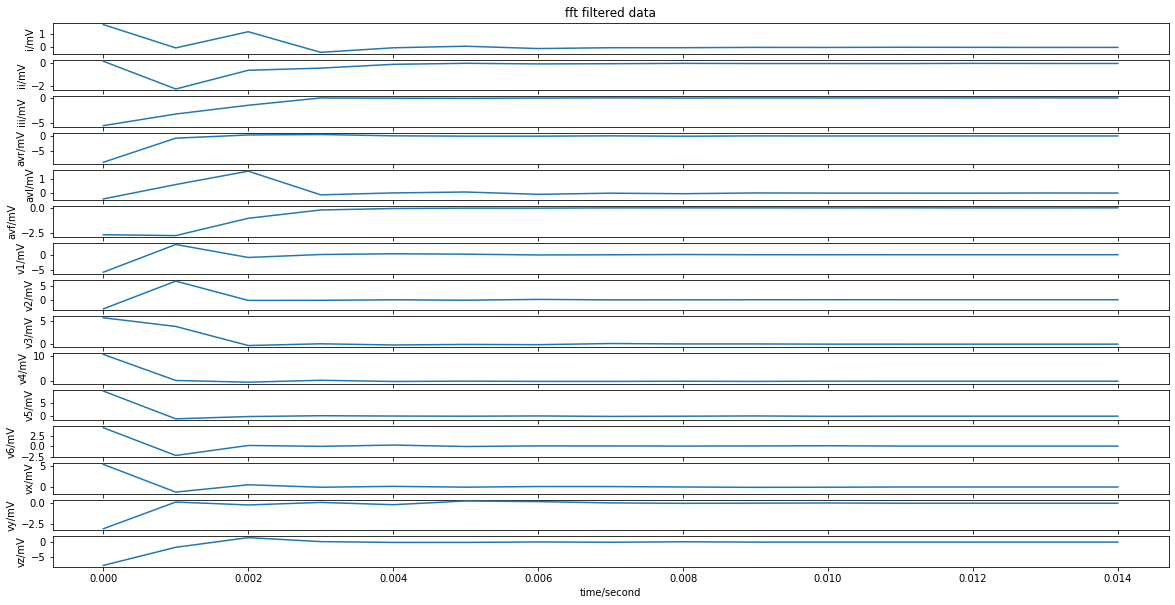

In [42]:
# Show FFT plots for a raw and filtered healthy sample and pca reduced

num_plots = 1
plot_count = 0

for i in range(len(record_files)):
  record_file = random.choice(record_files)
  record_data = wfdb.io.rdrecord(record_file, sampto=10000)
  channel_data = record_data.p_signal.transpose()

  diagnosis = record_data.comments[4]

  if plot_count is num_plots:
    break

  if 'Healthy' in diagnosis:
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="raw data",
                  figsize=(20,10))
    
    record_data.p_signal = np.abs(fft(channel_data))[:, :int(channel_data.shape[1]/2)].astype(np.float).transpose()
    
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="fft raw data",
                  figsize=(20,10), plot_sym=False)

    b, a = signal.butter(N=5, Wn=10 / (record_data.fs/2), btype='highpass', output='ba')   

    filtered_data = np.empty_like(channel_data)
    for idx in range(channel_data.shape[0]):
        filtered_data[idx, :] = signal.filtfilt(b, a, channel_data[idx, :])

    record_data.p_signal = filtered_data.transpose()

    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="filtered data",
                  figsize=(20,10), plot_sym=False)   
    
    record_data.p_signal = np.abs(fft(filtered_data))[:, :int(filtered_data.shape[1]/2)].astype(np.float).transpose()
    
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="fft filtered data",
                  figsize=(20,10), plot_sym=False)
    
    pca = PCA(n_components=15)
    pca.fit(filtered_data)
    record_data.p_signal = pca.transform(filtered_data).transpose()

    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="pca reduced filtered data",
                  figsize=(20,10), plot_sym=False)

    plot_count += 1

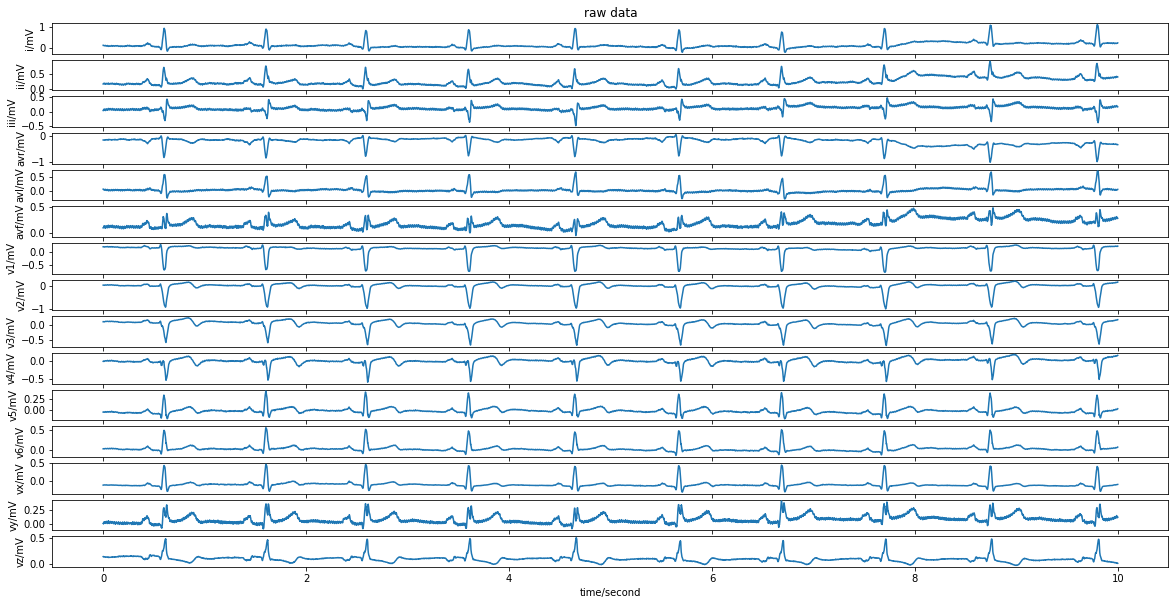

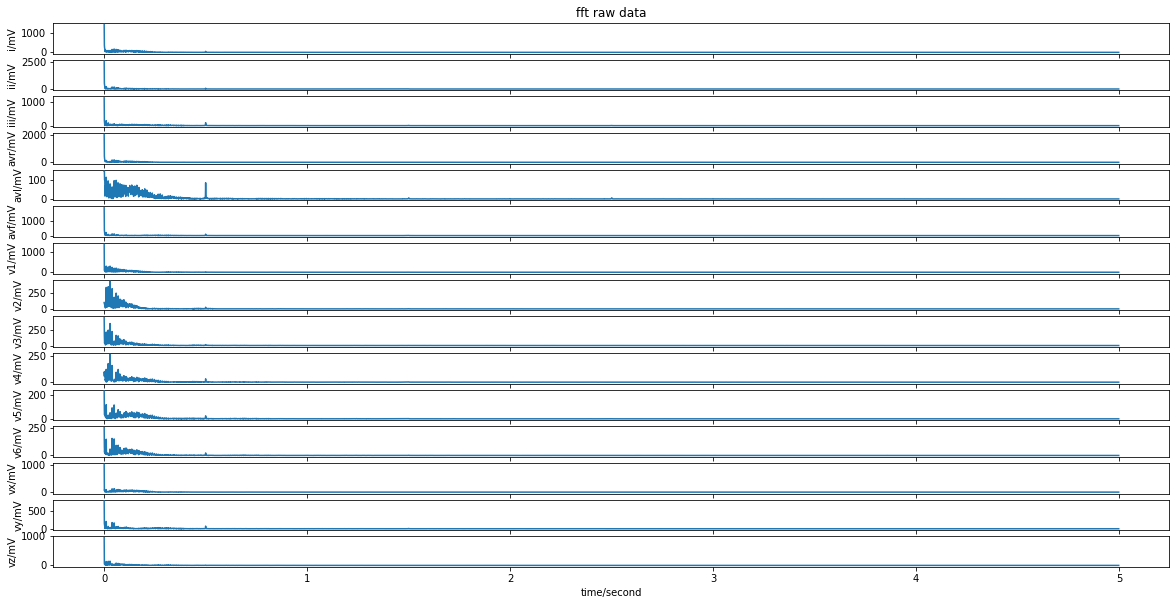

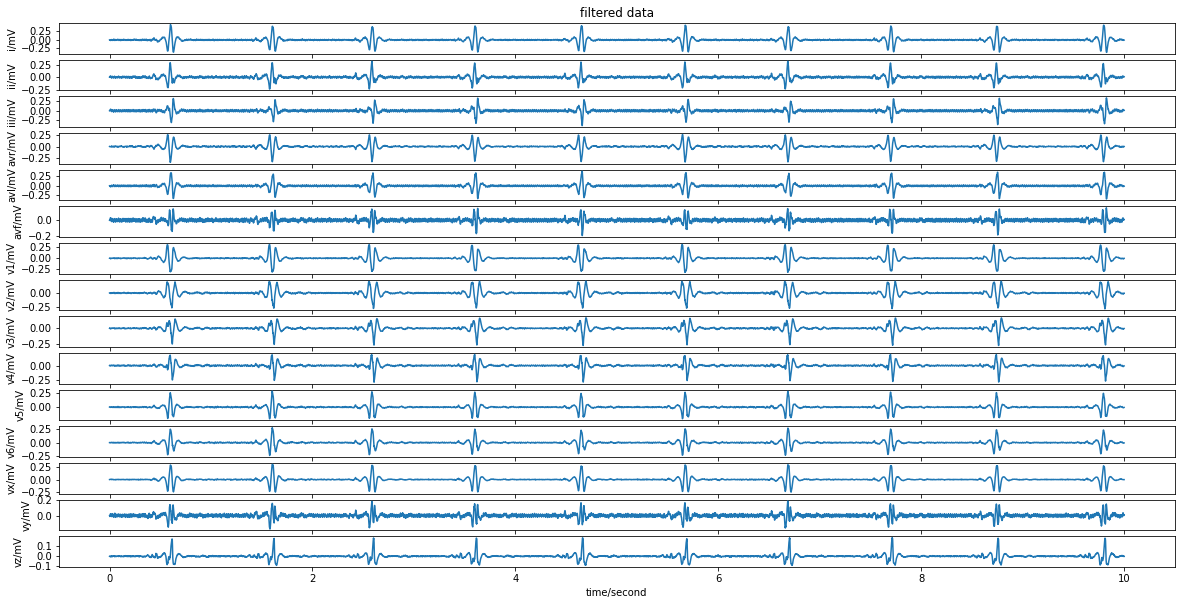

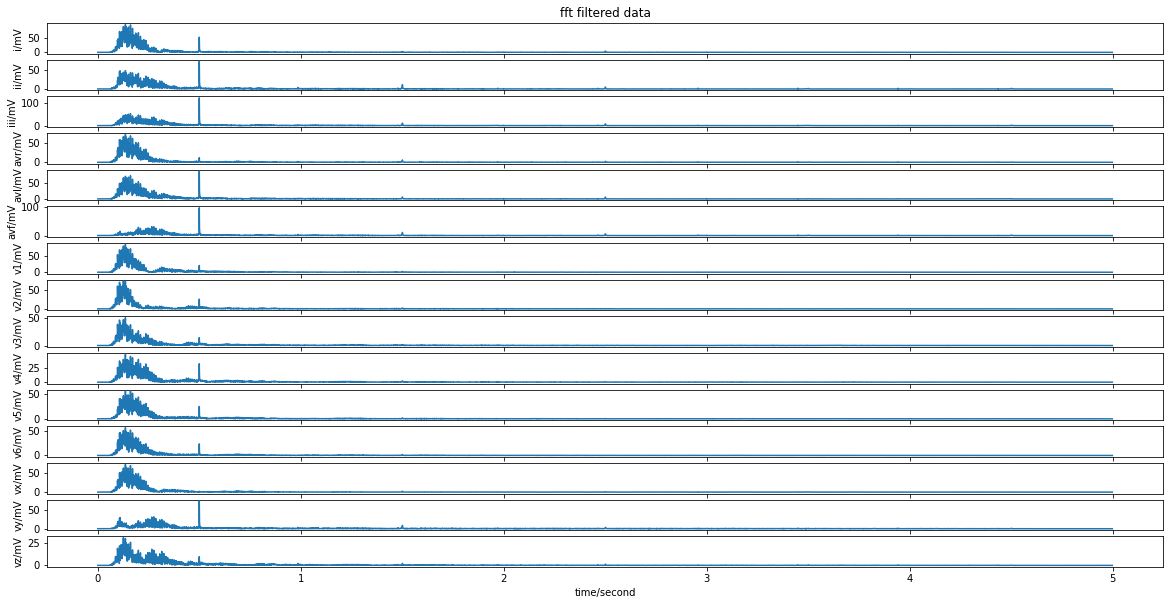

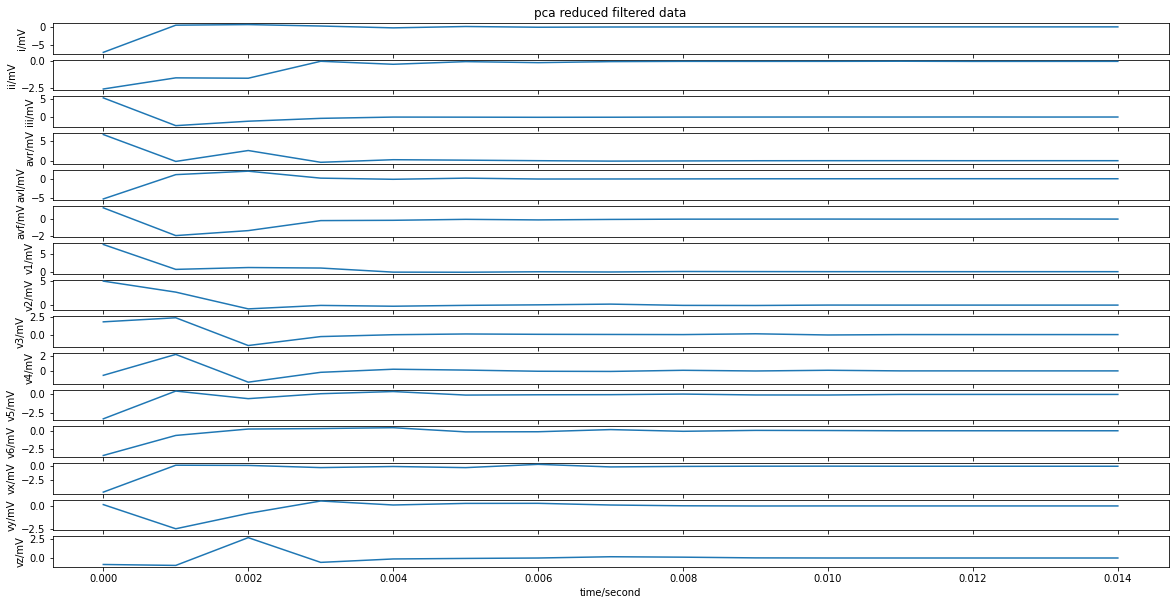

In [43]:
# Show FFT plots for a raw and filtered unhealthy sample and pca reduced

num_plots = 1
plot_count = 0

for i in range(len(record_files)):
  record_file = random.choice(record_files)
  record_data = wfdb.io.rdrecord(record_file, sampto=10000)
  channel_data = record_data.p_signal.transpose()

  diagnosis = record_data.comments[4]

  if plot_count is num_plots:
    break

  if 'Myocardial' in diagnosis:
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="raw data",
                  figsize=(20,10))
    
    record_data.p_signal = np.abs(fft(channel_data))[:, :int(channel_data.shape[1]/2)].astype(np.float).transpose()
    
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="fft raw data",
                  figsize=(20,10), plot_sym=False)

    b, a = signal.butter(N=5, Wn=10 / (record_data.fs/2), btype='highpass', output='ba')   

    filtered_data = np.empty_like(channel_data)
    for idx in range(channel_data.shape[0]):
        filtered_data[idx, :] = signal.filtfilt(b, a, channel_data[idx, :])

    record_data.p_signal = filtered_data.transpose()

    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="filtered data",
                  figsize=(20,10), plot_sym=False)   
    
    record_data.p_signal = np.abs(fft(filtered_data))[:, :int(filtered_data.shape[1]/2)].astype(np.float).transpose()
    
    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="fft filtered data",
                  figsize=(20,10), plot_sym=False)
    
    pca = PCA(n_components=15)
    pca.fit(filtered_data)
    record_data.p_signal = pca.transform(filtered_data).transpose()

    wfdb.plot_wfdb(record=record_data,
                  time_units='seconds', title="pca reduced filtered data",
                  figsize=(20,10), plot_sym=False)

    plot_count += 1

A cutoff frequency of 10 seems to be reasonable. Let's investigate the correct number of PCA components.

In [75]:
all_filtered_data = np.empty((len(record_files)*15, 10000))

for i, record_file in enumerate(record_files):

  record_data = wfdb.io.rdrecord(record_file, sampto=10000)
  channel_data = record_data.p_signal.transpose()

  b, a = signal.butter(N=5, Wn=10 / (record_data.fs/2), btype='highpass', output='ba')   

  filtered_data = np.empty_like(channel_data)
  for idx in range(channel_data.shape[0]):
      filtered_data[idx, :] = signal.filtfilt(b, a, channel_data[idx, :])

  all_filtered_data[i*15: (i+1)*15, :] = filtered_data

pca = PCA(n_components=15)
pca.fit(all_filtered_data)
reduced_filtered_data = pca.transform(filtered_data).transpose()
print(pca.explained_variance_ratio_)

[0.03462543 0.01659803 0.01519372 0.01361202 0.0116937  0.0104427
 0.0096076  0.0091391  0.00889951 0.00867279 0.00851319 0.0082096
 0.0080974  0.00802904 0.00792206]


14 PCA components are enough as the last one doesn't contain much info

In [ ]:
for record_file in record_files:

  record_data = wfdb.io.rdrecord(record_file, sampto=10000)
  channel_data = record_data.p_signal.transpose()

  b, a = signal.butter(N=5, Wn=10 / (record_data.fs/2), btype='highpass', output='ba')   

  filtered_data = np.empty_like(channel_data)
  for idx in range(channel_data.shape[0]):
      filtered_data[idx, :] = signal.filtfilt(b, a, channel_data[idx, :])

  pca = PCA(n_components=15)
  pca.fit(filtered_data)
  reduced_filtered_data = pca.transform(filtered_data).transpose()

x_embedded = TSNE(n_components=2, random_state=5).fit_transform(x)